In [75]:
from typing import Annotated
from typing_extensions import TypedDict
import os
from dotenv import load_dotenv
load_dotenv()

True

In [76]:
# using tools
from langchain_community.utilities import GoogleFinanceAPIWrapper,WikipediaAPIWrapper,ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun,ArxivQueryRun
from langchain_community.tools.google_finance import GoogleFinanceQueryRun

In [77]:
wiki_wrapper = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)
# arxive_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
# arxive_tool = ArxivQueryRun(arxive_wrapper)
# gf_wrapper = GoogleFinanceAPIWrapper()
# gf_tool = GoogleFinanceQueryRun(gf_wrapper)


In [78]:
wiki_tool.invoke("langchain")

"Page: LangChain\nSummary: LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis a"

In [79]:
from langgraph.graph import add_messages
class State(TypedDict):
    messages : Annotated[list,add_messages]


In [80]:
tools = [wiki_tool]

In [81]:
from langgraph.graph import StateGraph,START,END
graph_builder = StateGraph(State)

In [82]:
# from langchain_community.chat_models import ChatOllama
#from langchain_ollama import ChatOllama
from langchain_groq import ChatGroq


In [83]:
llm = ChatGroq(model='Gemma2-9b-it')

In [84]:
msg = llm.invoke("What is Artificial intellegence")
msg.content

"Artificial intelligence (AI) is a broad field in computer science focused on creating machines capable of performing tasks that typically require human intelligence. \n\nHere's a breakdown:\n\n**What AI aims to do:**\n\n* **Learn from data:** AI systems can analyze vast amounts of data to identify patterns, make predictions, and improve their performance over time.\n* **Solve problems:** AI can be used to solve complex problems, such as diagnosing diseases, recommending products, or optimizing logistics.\n* **Understand and respond to natural language:** AI-powered chatbots and virtual assistants can understand and respond to human language in a natural way.\n* **Recognize patterns and images:** AI can be used to recognize objects, faces, and other patterns in images and videos.\n* **Make decisions:** AI systems can be trained to make decisions based on data and algorithms.\n\n**Types of AI:**\n\n* **Narrow or Weak AI:**  AI systems designed to perform a specific task, like playing ch

In [85]:
llm_with_tools = llm.bind_tools(tools=tools)


In [86]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

In [87]:
from langgraph.prebuilt import ToolNode,tools_condition
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_edge(START,"chatbot")




In [88]:
tool_node = ToolNode(tools=tools)

In [89]:
graph_builder.add_node("tools",tool_node)

In [90]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

In [91]:
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge("chatbot",END)

In [92]:
graph = graph_builder.compile()

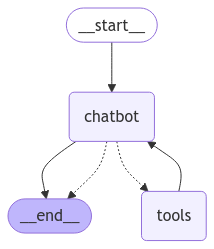

In [93]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [105]:
user_input = "Hi I am John"
events = graph.stream({'messages':("user",user_input)},stream_mode="values")
events

<generator object Pregel.stream at 0x7fb43c3d8420>

In [106]:
for event in events:
    print(event['messages'][-1].pretty_print())

================================ Human Message =================================

Hi I am John
None
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_x9x3)
 Call ID: call_x9x3
  Args:
    query: John
None


/official/official_docs/PythonLearning/GenerativeAIWithLangchainByKrish/projects/env/lib/python3.11/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /official/official_docs/PythonLearning/GenerativeAIWithLangchainByKrish/projects/env/lib/python3.11/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
None
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_rn2t)
 Call ID: call_rn2t
  Args:
    query: John Doe
None
================================= Tool Message =================================
Name: wikipedia

Page: John Doe
Summary: John Doe (male) and Jane Doe (female) are multiple-use placeholder names that are used in the British and US-American legal system and aside generally in the United Kingdom and the United States when the true name of a person is unknown or is being intentionally concealed. In
None
================================== Ai Message ==================================

That's interesting!  Is there anything else you'd like to know about John Doe?
None
